# KDE demo, with histosys!

> It works :)

![](assets/pyhf_3.gif)

## This depends on a *very* experimental fork of pyhf, install it by running the cell below:

In [1]:
!python -m pip install git+https://github.com/phinate/pyhf.git@diffable_json

  Cloning https://github.com/phinate/pyhf.git (to revision diffable_json) to /private/var/folders/nk/l3bpn5t13lg1qclxj08k_b800000gn/T/pip-req-build-snohxqmh
  Running command git clone -q https://github.com/phinate/pyhf.git /private/var/folders/nk/l3bpn5t13lg1qclxj08k_b800000gn/T/pip-req-build-snohxqmh
  Running command git checkout -b diffable_json --track origin/diffable_json
  Switched to a new branch 'diffable_json'
  Branch 'diffable_json' set up to track remote branch 'diffable_json' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 887 kB/s eta 0:00:01
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached jsonpointer-2.0-py2.py3-none-any.whl (7.6 kB)
  Created wheel for pyhf: filename=pyhf-0.4.1.dev6-py2.py3-none-any.whl size=96102 sha256=b995a76d0f92cd304941f027dd7f3afa12193fd1bae80e6

In [1]:
# import jax
import time

import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
import numpy as np

import neos.cls as cls
import neos.makers as makers
import pyhf

pyhf.set_backend(pyhf.tensor.jax_backend())

In [12]:
# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(2),
    stax.Softmax,
)

## Compose differentiable workflow

In [18]:
# choose hyperparams
bins = np.linspace(-5, 5, 3)
centers = bins[:-1] + np.diff(bins) / 2.0
bandwidth = 0.8 * 1 / (len(bins) - 1)

# compose functions from neos to define workflow
hmaker = makers.soft_bins_from_nn_histosys(predict, bins=bins, bandwidth=bandwidth)
nnm = makers.nn_histosys(hmaker)
loss = cls.cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))

bandwidth  # print bw

0.4

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [19]:
_, network = init_random_params(jax.random.PRNGKey(13), (-1, 2))
jax.grad(loss)(network, 1.0)

[(DeviceArray([[-6.39392965e-05,  2.49700708e-04,  6.68946072e-04, ...,
                -4.50172724e-04, -4.18919080e-04, -1.19110955e-04],
               [ 1.76239391e-05, -9.06179484e-05, -5.25184674e-04, ...,
                 3.21837259e-04,  3.40562430e-04,  2.65946408e-04]],            dtype=float32),
  DeviceArray([ 3.0846772e-05,  9.9425728e-05, -3.5840995e-04, ...,
                3.0089423e-04, -1.3085519e-04,  1.5730169e-04],            dtype=float32)),
 (),
 (DeviceArray([[-1.6656536e-06, -1.2146175e-07, -2.9841829e-08, ...,
                 1.2105947e-06,  1.5682476e-06,  3.1261172e-06],
               [ 1.9789358e-07, -2.7825121e-07, -8.9471207e-08, ...,
                 0.0000000e+00, -1.2808763e-07,  6.4175856e-09],
               [-9.3338542e-07,  3.4286121e-09,  1.5113590e-09, ...,
                 1.7381469e-06,  3.9040351e-06,  3.2826536e-06],
               ...,
               [-1.0275093e-06,  4.3981599e-06,  1.6695128e-06, ...,
                 2.9646089e-06,  1.8

### Define training loop!

In [20]:
# jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(1e-3)


@jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net


def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [21]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.3, c="C9")
    ax.scatter(hm.bkg_up[:, 0], hm.bkg_up[:, 1], alpha=0.1, c="C1", marker=6)
    ax.scatter(hm.bkg_down[:, 0], hm.bkg_down[:, 1], alpha=0.1, c="C1", marker=7)
    ax.scatter(hm.bkg_nom[:, 0], hm.bkg_nom[:, 1], alpha=0.3, c="C1")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.15)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$CL_s$")

    ax = axarr[2]
    s, b, bup, bdown = hm(network)

    bin_width = 1 / (len(bins) - 1)
    ax.bar(centers, b, color="C1", width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", width=bin_width)

    bunc = np.asarray([[x, y] if x > y else [y, x] for x, y in zip(bup, bdown)])
    plot_unc = []
    for unc, be in zip(bunc, b):
        if all(unc > be):
            plot_unc.append([max(unc), be])
        elif all(unc < be):
            plot_unc.append([be, min(unc)])
        else:
            plot_unc.append(unc)

    plot_unc = np.asarray(plot_unc)
    b_up, b_down = plot_unc[:, 0], plot_unc[:, 1]

    ax.bar(centers, b_up - b, bottom=b, alpha=0.4, color="black", width=bin_width)
    ax.bar(
        centers, b - b_down, bottom=b_down, alpha=0.4, color="black", width=bin_width
    )

    ax.set_ylim(0, 60)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

## Install celluloid to create animations if you haven't already by running this next cell:

In [8]:
!python -m pip install celluloid

### Let's run it!!

epoch 0: CLs = 0.06006098750648725, took 1.1654608249664307s
epoch 1: CLs = 0.029658807826066003, took 1.7045130729675293s
epoch 2: CLs = 0.010051825382171087, took 1.6470341682434082s
epoch 3: CLs = 0.0028889271642649206, took 1.6726288795471191s
epoch 4: CLs = 0.0009958122347739629, took 1.6810500621795654s
epoch 5: CLs = 0.00044376303484927604, took 1.8678128719329834s
epoch 6: CLs = 0.00024638882955696495, took 1.6775541305541992s
epoch 7: CLs = 0.00016073635587976476, took 1.8801820278167725s
epoch 8: CLs = 0.00011727254072391169, took 1.677398681640625s
epoch 9: CLs = 9.242899803552085e-05, took 1.6416497230529785s
epoch 10: CLs = 7.685206873020434e-05, took 1.6839051246643066s
epoch 11: CLs = 6.636317597341623e-05, took 1.6808960437774658s
epoch 12: CLs = 5.888994927860658e-05, took 1.7374389171600342s
epoch 13: CLs = 5.3331846957105356e-05, took 1.7443640232086182s
epoch 14: CLs = 4.9035717989420746e-05, took 1.7651867866516113s
epoch 15: CLs = 4.560569567524375e-05, took 1.747

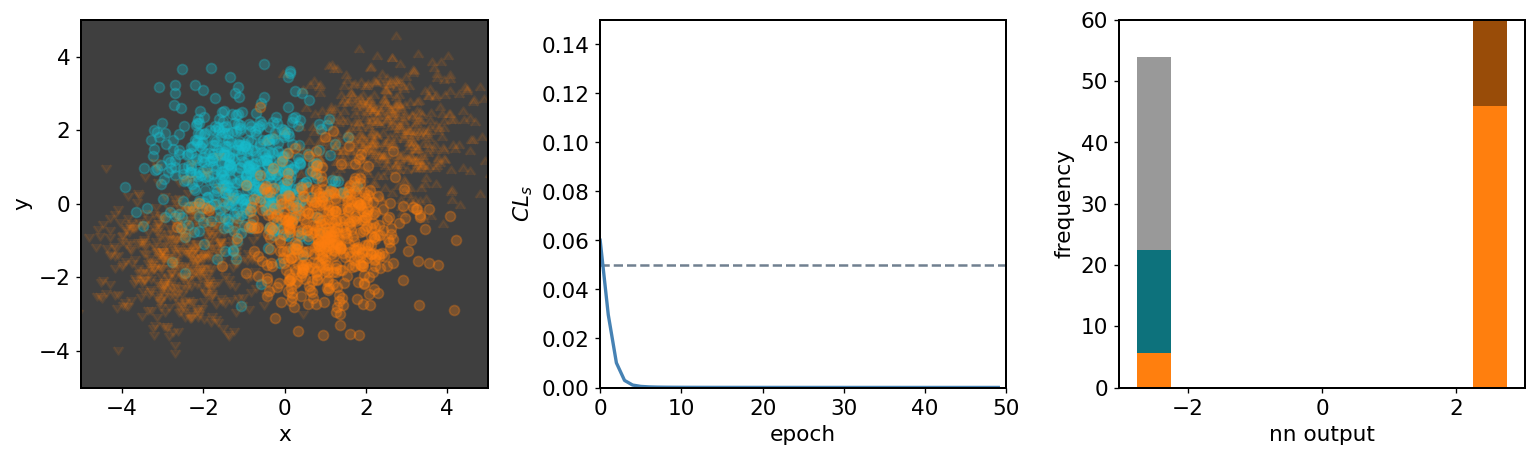

In [22]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 4.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)

maxN = 50  # make me bigger for better results!

animate = True  # animations fail tests...

if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            # HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)